# Computer Exercise 1 &mdash; Computer Exercise

In this computer exercise we will look at
<ul>
    <li>Matrix computations in NumPy and Python</li>
    <li>Homography estimation using DLT</li>
    <li>The SVD profile and the number of solutions</li>
    <li>Geometric vs algebraic errors</li>
</ul>

In [1]:
### Import python modules for linear algebra (numpy) and plotting (matplotlib).

import numpy as np
from matplotlib import pyplot as plt

%matplotlib notebook
np.set_printoptions(precision = 2, suppress = True)


# Create list with teacher tokens.
teacher_tokens = set()

## 1. Lightning intro to Python and NumPy arrays

In this computer exercise, we will use [Python](https://docs.python.org/3/tutorial/), [NumPy](https://numpy.org/doc/stable/user/quickstart.html), and [Matplotlib](https://matplotlib.org/tutorials/introductory/pyplot.html).
It is recommended that you scroll through the links for NumPy and Matplotlib for a few minutes before starting the computer exercise.
In the following few cells are some examples of basic operations on NumPy arrays, that you are likely to need in this exercise.

In [2]:
# Matrices are represented in NumPy using np.array, and can be entered elementwise as:
A = np.array([[1, 2, 3],
              [4, 5, 6]])

print(A[0,0])
print(abs(-2))
print('A == \n', A, '\n')

# Addition of matrices, and multiplication by a scalar work as expected,
# so we do not provide an example. You can make one up and try.

# We can access the dimensions of a matrix A through A.shape, which is a tuple:
print('A.shape is', A.shape, 'meaning that A is a ' + str(A.shape[0]) + '-by-' + str(A.shape[1]) + ' matrix\n')

# The transpose of A is written A.T:
print('A.T == \n', A.T, '\n')

# We can work with individual entries of matrices (note that Python is zero-indexed!):
print('A[1, 1] == ', A[1, 1], '\n')
# Change the entry:
A[1, 1] = 2
print('A == \n', A, '\n')

1
2
A == 
 [[1 2 3]
 [4 5 6]] 

A.shape is (2, 3) meaning that A is a 2-by-3 matrix

A.T == 
 [[1 4]
 [2 5]
 [3 6]] 

A[1, 1] ==  5 

A == 
 [[1 2 3]
 [4 2 6]] 



In [3]:
# NumPy has an annoying tendency to forget dimensions, especially
# of things we expect to be n-by-1, such as columns (also rows, which should be 1-by-n):
print('A[:, 0] ==', A[:, 0], ' has dimensions ' \
    + str(A[:, 0].shape) + ', not (2, 1) as one would expect. Avoid indexing with single columns!\n')
# There are various ugly workarounds:
print('A[:, 0:1] == \n', A[:, 0:1], ' has dimensions ' + str(A[:, 0:1].shape) + '\n')
print('A[:, 0, None] == \n', A[:, 0, None], ' has dimensions ' + str(A[:, 0, None].shape) + '\n')

# Matrices can sometimes be appended to form a larger matrix using np.append, but NumPy tends
# to forget the dimensions unless you specify the direction using axis = 0 or axis = 1:
print('np.append(A, 2 * A, axis = 0) ==\n', np.append(A, 2 * A, axis = 0), '\n')

A[:, 0] == [1 4]  has dimensions (2,), not (2, 1) as one would expect. Avoid indexing with single columns!

A[:, 0:1] == 
 [[1]
 [4]]  has dimensions (2, 1)

A[:, 0, None] == 
 [[1]
 [4]]  has dimensions (2, 1)

np.append(A, 2 * A, axis = 0) ==
 [[ 1  2  3]
 [ 4  2  6]
 [ 2  4  6]
 [ 8  4 12]] 



In [4]:
# You can create identity matrices using np.eye,
# matrices filled with ones with np.ones,
# zero matrices using np.zeros:
I3 = np.eye(3)
B = np.ones((2, 2))
print('I3 == \n', I3, '\n')
print('B == \n', B, '\n')

# Matrices with compatible dimensions can be multiplied using the operator @:
print('B @ A == \n', B @ A, '\n')
print('A @ A.T == \n', A @ A.T, '\n')

# Systems of equations Mx = b can be solved using the pseudo-inverse:
M = np.array([[1, 2],
              [3, 4]])
b = np.array([[0], [2]])
x = np.linalg.pinv(A) @ b
print('x == \n', x, '\n')

I3 == 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

B == 
 [[1. 1.]
 [1. 1.]] 

B @ A == 
 [[5. 4. 9.]
 [5. 4. 9.]] 

A @ A.T == 
 [[14 26]
 [26 56]] 

x == 
 [[ 0.56]
 [-0.44]
 [ 0.11]] 



In [5]:
# The Kronecker product can be computed using np.kron,
# and vectorisation of a matrix A can be done through
# A.reshape((-1, 1), order = 'F'):
print('np.kron(B, A) == \n', np.kron(B, A), '\n')
print('vec(A) == \n', A.reshape((-1, 1), order = 'F'))

np.kron(B, A) == 
 [[1. 2. 3. 1. 2. 3.]
 [4. 2. 6. 4. 2. 6.]
 [1. 2. 3. 1. 2. 3.]
 [4. 2. 6. 4. 2. 6.]] 

vec(A) == 
 [[1]
 [4]
 [2]
 [2]
 [3]
 [6]]


In [6]:
### Define some utility functions.

def cart_to_hom(y):
    """takes an array with Cartesian coordinates as its columns,
        and returns an array with a homogeneous representation."""
    return np.append(y, np.ones((1,4)), axis = 0)

def norm_P(y):
    """takes an array with homogeneous coordinates as its columns,
        and returns an array with P-normalised homogeneous coordinates
        as its columns."""
    return y / np.tile(y[-1, :], (y.shape[0], 1))

def norm_D(l):
    """takes an array with dual homogeneous coordinates as its columns,
        and returns an array with D-normalised dual homogeneous cordinates
        as its columns."""
    normal_norms = np.tile(np.sqrt(np.power(l[:-1, :], 2).sum(axis = 0)), (l.shape[0], 1))
    last_signs = np.tile(np.sign(l[-1, :]), (l.shape[0], 1))
    return -last_signs * l / normal_norms

def crossm(v):
    """takes a vector v of lenght 3, and returns the cross product matrix of v."""
    assert np.prod(v.shape) == 3
    return np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]],[-v[1], v[0], 0]])

## 2. Extracting a homography from a DLT system

Consider six point correspondences $\mathbf{y}_k \leftrightarrow \mathbf{y}_k'$, defined by
$$
    \mathbf{Y} =
    \begin{pmatrix}
        \color{red}{\mathbf{y}_1} & \ldots & \mathbf{y}_6
    \end{pmatrix}
    =
    \begin{pmatrix}
        \color{red}{0} & 1 & 1 & 2 & 1 & 0 \\
        \color{red}{0} & 2 & 4 & 1 & 0 & 1 \\
        \color{red}{1} & 1 & 1 & 1 & 1 & 1 \\
    \end{pmatrix}
$$
and
$$
    \mathbf{Y}' =
    \begin{pmatrix}
        \color{red}{\mathbf{y}_1'} & \ldots & \mathbf{y}_6'
    \end{pmatrix}
    =
    \begin{pmatrix}
        \color{red}{1} & -3 & -2 & 2 & 0 & -4 \\
        \color{red}{-2} & -1 & -1 & 0 & -1 & 0 \\
        \color{red}{1} & 1 & 1 & 1 & 1 & 1 \\
    \end{pmatrix}
    ,
$$

where the points involved in the correspondence $\mathbf{y}_1 \leftrightarrow \mathbf{y}_1'$ have been coloured in red only to help visualisation.
The matrices $\mathbf{Y}$ and $\mathbf{Y}'$ are entered in the code cell below as `Y` and `Yprime`, respectively.

In fact, these six point correspondences are related through a homography $\mathbf{H}$, such that $\mathbf{y}_k' \sim \mathbf{H}\mathbf{y}_k$ for $k = 1,\ldots,6$.
As we have seen in the lectures, $\mathbf{H}$ can be found by computing the null space of the data matrix $\mathbf{A}$ formed from the *Direct Linear Transformation* (DLT) constraints, since $\mathbf{A}\operatorname{vec}{\mathbf{H}} = \mathbf{0}$.
The data matrix in this particular example is entered as `A` in the code cell below.


### Task: use the inhomogeneous method to find $\mathbf{H}_\text{inh}$ from the DLT system.

<ul>
    <li>Recall that the inhomogeneous method is based on rewriting $\mathbf{A}\mathbf{z} = \mathbf{0}$ as $\begin{pmatrix} \mathbf{A}_0 & \mathbf{b} \end{pmatrix}\begin{pmatrix} \mathbf{z}_0 \\ 1 \end{pmatrix} = \mathbf{0}$ and solving for $\mathbf{z}_0$.</li>
    <li>You will likely find <code>np.linalg.pinv</code> useful here.</li>
    <li>You will likely find <code>np.append</code> and <code>np.reshape</code> useful here to form $\mathbf{H}_\text{inh}$ from $\mathbf{z}_0$.</li>
</ul>

In [7]:
### Define point correspondences and the data matrix.

Y = np.array([[0, 1, 1, 2, 1, 0],
              [0, 2, 4, 1, 0, 1],
              [1, 1, 1, 1, 1, 1]])

Yprime = np.array([[1, -3, -2, 2, 0, -4],
                   [-2, -1, -1, 0, -1, 0],
                   [1, 1, 1, 1, 1, 1]])

A = np.array([[0, 0, 0, 0, 0, 0, 0, -1, -2],
              [0, 0, 0, 0, 0, 0, 1, 0, -1],
              [0, -1, -1, 0, -2, -2, 0, -1, -1],
              [1, 0, 3, 2, 0, 6, 1, 0, 3],
              [0, -1, -1, 0, -4, -4, 0, -1, -1],
              [1, 0, 2, 4, 0, 8, 1, 0, 2],
              [0, -2, 0, 0, -1, 0, 0, -1, 0],
              [2, 0, -4, 1, 0, -2, 1, 0, -2],
              [0, -1, -1, 0, 0, 0, 0, -1, -1],
              [1, 0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, -1, 0, 0, -1, 0],
              [0, 0, 0, 1, 0, 4, 1, 0, 4]])


# Hinhom = ...?
# YOUR CODE HERE

B = A[:,8]
A0 = A[:,0:8]

z_0 = -(np.linalg.pinv(A0)@B)
z = np.append(z_0,1)

Hinhom = np.reshape(z, (3,3)).T

print(Hinhom)
print('A=\n',A)
print('B=\n',B) 
print('A0=\n',A0)
print ('z_0 = \n', z_0)
print ('z = \n', z)

#raise NotImplementedError()

print('Hinhom @ Y:')
print(norm_P(Hinhom @ Y))
print('\nYprime:')
print(Yprime)

[[-1.  3.  1.]
 [ 0.  2. -2.]
 [ 1. -2.  1.]]
A=
 [[ 0  0  0  0  0  0  0 -1 -2]
 [ 0  0  0  0  0  0  1  0 -1]
 [ 0 -1 -1  0 -2 -2  0 -1 -1]
 [ 1  0  3  2  0  6  1  0  3]
 [ 0 -1 -1  0 -4 -4  0 -1 -1]
 [ 1  0  2  4  0  8  1  0  2]
 [ 0 -2  0  0 -1  0  0 -1  0]
 [ 2  0 -4  1  0 -2  1  0 -2]
 [ 0 -1 -1  0  0  0  0 -1 -1]
 [ 1  0  0  0  0  0  1  0  0]
 [ 0  0  0  0 -1  0  0 -1  0]
 [ 0  0  0  1  0  4  1  0  4]]
B=
 [-2 -1 -1  3 -1  2  0 -2 -1  0  0  4]
A0=
 [[ 0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  1  0]
 [ 0 -1 -1  0 -2 -2  0 -1]
 [ 1  0  3  2  0  6  1  0]
 [ 0 -1 -1  0 -4 -4  0 -1]
 [ 1  0  2  4  0  8  1  0]
 [ 0 -2  0  0 -1  0  0 -1]
 [ 2  0 -4  1  0 -2  1  0]
 [ 0 -1 -1  0  0  0  0 -1]
 [ 1  0  0  0  0  0  1  0]
 [ 0  0  0  0 -1  0  0 -1]
 [ 0  0  0  1  0  4  1  0]]
z_0 = 
 [-1.  0.  1.  3.  2. -2.  1. -2.]
z = 
 [-1.  0.  1.  3.  2. -2.  1. -2.  1.]
Hinhom @ Y:
[[ 1. -3. -2.  2. -0. -4.]
 [-2. -1. -1.  0. -1. -0.]
 [ 1.  1.  1.  1.  1.  1.]]

Yprime:
[[ 1 -3 -2  2  0 -4]
 [-2 -1

<IPython.core.display.Javascript object>


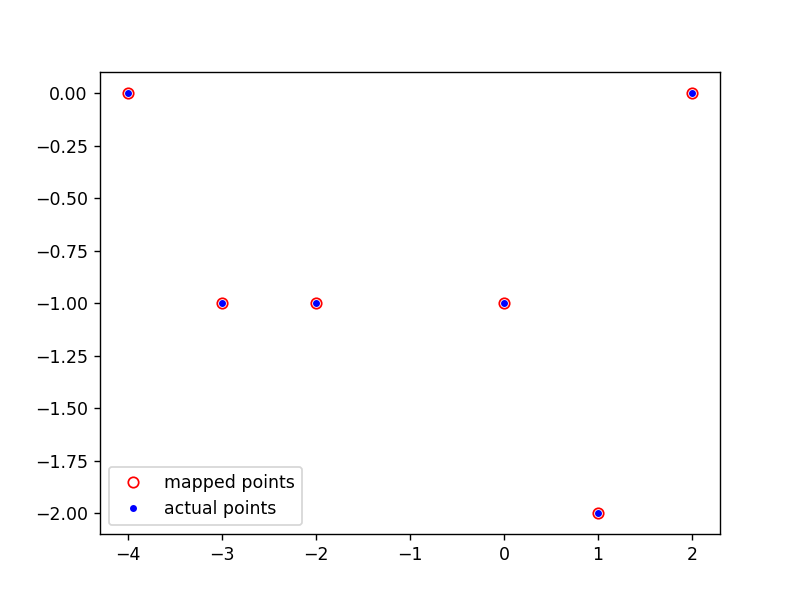

In [18]:
# We can also plot the points and see that they overlap:
plt.plot(norm_P(Hinhom @ Y)[0, :], norm_P(Hinhom @ Y)[1, :], 'ro', mfc = 'None', mec = 'r')
plt.plot(Yprime[0, :], Yprime[1, :], 'b.')
plt.legend(['mapped points', 'actual points'])
plt.show()

In [9]:
# Verify that the points are mapped correctly (to high precision).
assert np.linalg.norm(Yprime - norm_P(Hinhom @ Y)) < 1e-10

### Task: use the singular value decomposition to find $\mathbf{H}_\text{svd}$ from the DLT system.

<ul>
    <li>As this is something that will be done repeatedly, you may want to create a function for this (optional).</li>
    <li>Be careful with the transposes! Note that <code>np.linalg.svd</code> returns $\mathbf{V}^\top$, not $\mathbf{V}$.</li>
    <li>You will likely find <code>np.reshape</code> useful here, to reshape $\operatorname{vec}{\mathbf{H}_\text{svd}}$ back to $\mathbf{H}_\text{svd}$.</li>
    <li>Do you obtain the same homography using the two methods, i.e., is $\mathbf{H}_\text{inh} \sim \mathbf{H}_\text{svd}$?</li>
    <li><b>Note:</b> <span style="color: red;">You need a TeacherToken for the answer here!</span></li>
</ul>



In [10]:
# Hsvd = ...?
# YOUR CODE HERE
#raise NotImplementedError()

u, S, v = np.linalg.svd(A)
vend = v.T
vend = vend[:, 8]
print(v.T)
print(vend)
print('s\n', S)

Hsvd = np.reshape(vend, (3,3)).T
print('Hsvd\n', Hsvd)
print(Hinhom)
print('Hsvd @ Y:')
print(norm_P(Hsvd @ Y))
print('\nYprime:')
print(Yprime)

teacher_tokens.add('63JS-QOG9')



[[-0.05  0.27  0.33 -0.08  0.29 -0.46  0.29  0.62 -0.2 ]
 [-0.04 -0.3   0.21 -0.09  0.59  0.28 -0.62  0.23 -0.  ]
 [-0.3  -0.31 -0.53  0.49  0.36 -0.31  0.15  0.06  0.2 ]
 [-0.26  0.44  0.21  0.08  0.28  0.4   0.28 -0.09  0.6 ]
 [-0.12 -0.62  0.54  0.04 -0.31 -0.15  0.15  0.07  0.4 ]
 [-0.82  0.1   0.16  0.19 -0.23  0.1  -0.16 -0.05 -0.4 ]
 [-0.09  0.22  0.18 -0.15  0.16 -0.64 -0.36 -0.53  0.2 ]
 [-0.04 -0.3   0.16 -0.22  0.43  0.09  0.5  -0.48 -0.4 ]
 [-0.38 -0.11 -0.38 -0.79 -0.07 -0.03  0.05  0.16  0.2 ]]
[-0.2 -0.   0.2  0.6  0.4 -0.4  0.2 -0.4  0.2]
s
 [14.34  5.53  4.85  3.54  2.34  1.67  1.28  0.93  0.  ]
Hsvd
 [[-0.2  0.6  0.2]
 [-0.   0.4 -0.4]
 [ 0.2 -0.4  0.2]]
[[-1.  3.  1.]
 [ 0.  2. -2.]
 [ 1. -2.  1.]]
Hsvd @ Y:
[[ 1. -3. -2.  2.  0. -4.]
 [-2. -1. -1.  0. -1. -0.]
 [ 1.  1.  1.  1.  1.  1.]]

Yprime:
[[ 1 -3 -2  2  0 -4]
 [-2 -1 -1  0 -1  0]
 [ 1  1  1  1  1  1]]


In [11]:
# Verify that the points are mapped correctly (to high precision).
assert np.linalg.norm(Yprime - norm_P(Hsvd @ Y)) < 1e-10

## 3. Number of solutions, a taste of SVD profile

The points in Section 2 were mapped to each other *exactly* by the homography.
There could potentially exist more than one homography which accomplishes this, even when taking the homogeneity of $\mathbf{H}$ into account.

In general, to be able to say something intelligently about the solution space, we can look at the singular values of the data matrix.
The configuration of their relative sizes is referred to as the *SVD profile* of the data matrix.
The SVD profile of the data matrix in Section 2 is plotted in the following cell (we plot the $\log_{10}$ of the singular values to make the plot more readable).

### Task: explain to a lab assistant how the SVD profile relates to the nullspace (and hence to the solutions)

<ul>
    <li>With six <i>exact</i> point correspondences, what do you expect $\operatorname{rank}{\mathbf{A}}$ to be?</li>
    <li>How many solutions do we have in this particular case?</li>
    <li>Considering how the rank relates to the singular values, are you surprised by the SVD profile in the plot below?</li>
    <li>Could the rank be greater? In what situations?</li>
    <li>Could the rank be smaller? In what situations?</li>
    <li><b>Note:</b> <span style="color: red;">You need a TeacherToken for the answer here!</span></li>
</ul>

<IPython.core.display.Javascript object>


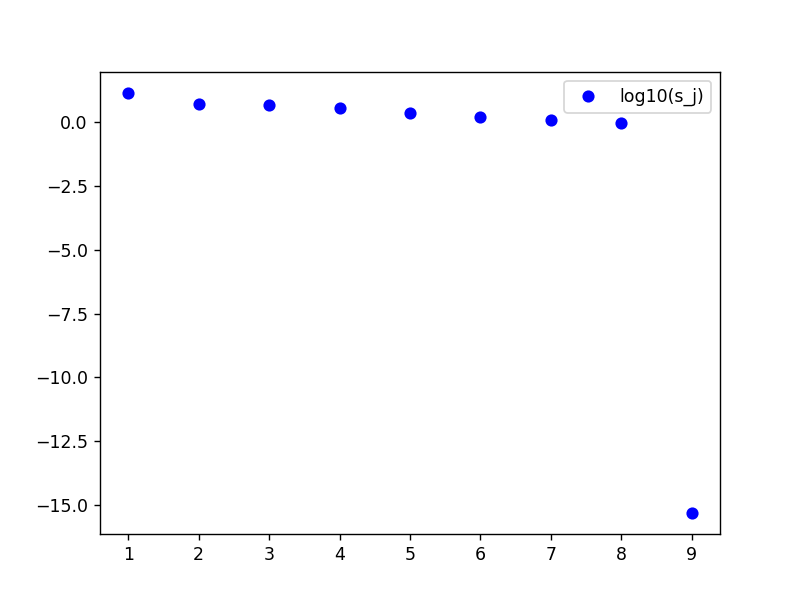

In [21]:
plt.plot(np.arange(1, 10), np.log10(S), 'bo')
plt.legend(['log10(s_j)'])
plt.show()

teacher_tokens.add('SLV5-MA0Z')
teacher_tokens.add('F68R-HPA5')
teacher_tokens.add('5X6E-R466')

## 4. Autogenerating the DLT system from point correspondences

Forming the DLT system by hand is error-prone drudgery, so we want a function that autogenerates it for us from point correspondences we provide.
As we have mentioned before in the course, since $\operatorname{rank}\big(\mathbf{y}_k^\top \otimes [\mathbf{y}_k']_\times\big) = 2$, we only have to use two rows to form $\mathbf{A}_k$.
For *proper points*, it is safe to use the first two rows of $\mathbf{y}_k^\top \otimes [\mathbf{y}_k']_\times$.
For *ideal points* the first two rows may be linearly dependent, and to be safe in this case, we use all three rows (we do not know in advance which row to remove).


### Task: implement the `dlt_system` function.

In [13]:
def dlt_system(Y, Yprime, full_system = False):
    """Input:
        | Y - a 3-by-n array with homogeneous coordinates as its columns
        | Yprime - a 3-by-n array with homogeneous coordinates as its columns
        | full_system - boolean, False by default

        Output:
        | if full_system is False - a 2n-by-9 data matrix for DLT
        | if full_system is True - a 3n-by-9 data matrix for DLT"""

    assert Y.shape[0] == 3
    assert np.all(Y.shape == Yprime.shape)

    nbr_points = Y.shape[1]
    nbr_rows_per_point = (2 + full_system)
    nbr_rows = nbr_rows_per_point * nbr_points
    A = np.zeros((nbr_rows, 9))

    # YOUR CODE HERE
      
    for i in range(nbr_points):
        A[2*i:2*(i+1),:] = np.kron(Y[:,i].T, crossm(Yprime[:,i]))[0:2,:]
   
    return A
print(A)
# If your implementation is correct, this should print the data matrix A from Section 2.
print(dlt_system(Y, Yprime))
print(A == dlt_system(Y,Yprime))

[[ 0  0  0  0  0  0  0 -1 -2]
 [ 0  0  0  0  0  0  1  0 -1]
 [ 0 -1 -1  0 -2 -2  0 -1 -1]
 [ 1  0  3  2  0  6  1  0  3]
 [ 0 -1 -1  0 -4 -4  0 -1 -1]
 [ 1  0  2  4  0  8  1  0  2]
 [ 0 -2  0  0 -1  0  0 -1  0]
 [ 2  0 -4  1  0 -2  1  0 -2]
 [ 0 -1 -1  0  0  0  0 -1 -1]
 [ 1  0  0  0  0  0  1  0  0]
 [ 0  0  0  0 -1  0  0 -1  0]
 [ 0  0  0  1  0  4  1  0  4]]
[[ 0.  0.  0.  0.  0.  0.  0. -1. -2.]
 [ 0.  0.  0.  0.  0.  0.  1.  0. -1.]
 [ 0. -1. -1.  0. -2. -2.  0. -1. -1.]
 [ 1.  0.  3.  2.  0.  6.  1.  0.  3.]
 [ 0. -1. -1.  0. -4. -4.  0. -1. -1.]
 [ 1.  0.  2.  4.  0.  8.  1.  0.  2.]
 [ 0. -2.  0.  0. -1.  0.  0. -1.  0.]
 [ 2.  0. -4.  1.  0. -2.  1.  0. -2.]
 [ 0. -1. -1.  0.  0.  0.  0. -1. -1.]
 [ 1.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0. -1.  0.]
 [ 0.  0.  0.  1.  0.  4.  1.  0.  4.]]
[[ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]

In [14]:
# Verify that dlt_system gives the desired result.
assert np.linalg.norm(A - dlt_system(Y, Yprime)) < 1e-10

## 5. Transforming random points, SVD profile

We will now consider homography estimation using random point correspondences.
This will allow us to see how the SVD profile behaves when we do not have exact correspondences.

### Task: vary the number of points and investigate what happens to the point mapping and the SVD profile

<ul>
    <li>Let $n$ be the number of point correspondences we use. For which values of $n$ is the mapping good?</li>
    <li>Can we tell from the SVD profile whether the homography mapping will be good or bad?</li>
    <li><b>Note:</b> <span style="color: red;">You need a TeacherToken for the answer here!</span></li>
</ul>

A
 [[ -0.     1.04  -0.75  -0.     4.93  -3.56   0.    -1.     0.72]
 [ -1.04  -0.     0.1   -4.93  -0.     0.48   1.     0.    -0.1 ]
 [  0.    -0.62   0.54  -0.     4.42  -3.84   0.    -1.     0.87]
 [  0.62   0.     1.62  -4.42  -0.   -11.51   1.     0.     2.6 ]
 [  0.    -0.28  -0.14  -0.     0.53   0.26   0.    -1.    -0.5 ]
 [  0.28   0.    -0.22  -0.53  -0.     0.41   1.     0.    -0.78]
 [ -0.     0.29   0.75   0.    -0.21  -0.54   0.    -1.    -2.6 ]
 [ -0.29  -0.     0.08   0.21   0.    -0.06   1.     0.    -0.27]]
S
 [14.03  6.87  4.67  3.1   1.48  1.32  0.73  0.55]
V
 [[-0.03 -0.01 -0.1   0.31 -0.21  0.9  -0.07  0.05 -0.2 ]
 [-0.03 -0.04  0.12 -0.55 -0.8   0.01  0.12  0.18  0.  ]
 [-0.22  0.04 -0.1  -0.72  0.49  0.34  0.18 -0.13 -0.13]
 [ 0.04  0.05  0.23  0.06 -0.08 -0.19  0.08 -0.36 -0.87]
 [ 0.11  0.71 -0.51  0.07 -0.06 -0.09  0.38  0.21 -0.11]
 [ 0.03 -0.42  0.11  0.19  0.07  0.03  0.86  0.14  0.03]
 [ 0.42 -0.23 -0.5  -0.07 -0.17  0.02  0.07 -0.68  0.17]
 [-0.78  0.19

<IPython.core.display.Javascript object>


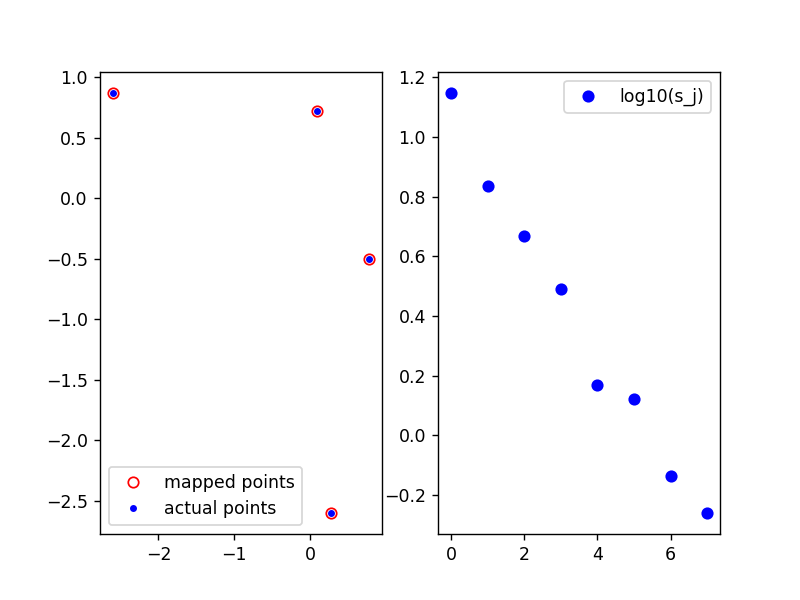

In [38]:
# Choose the number of correspondences to create.
n = 4
# good for n = 1-4.
# Can see in S and in dimensions of A. n>4 gives under-determined case. If size of S < 2n we have bad mapping
        
# Generate n random point correspondences.
Y = norm_P(np.random.randn(3, n))
Yprime = norm_P(np.random.randn(3, n))


# Create the DLT sytem and form H using the singular value decomposition.
# H = ...?
# YOUR CODE HERE
u, s, V = np.linalg.svd(dlt_system(Y, Yprime))
v = V.T
v = v[:, 8]
print('A\n', dlt_system(Y,Yprime))
print('S\n', s)
print('V\n', V)
print('u\n', u)

H = np.reshape(v, (3,3)).T

# Plot the actual points and the mapped points,
# as well as the SVD profile of the data matrix.
Ymapped = norm_P(H @ Y)
plt.subplot(1, 2, 1)
plt.plot(Ymapped[0, :], Ymapped[1, :], 'ro', mfc = 'None', mec = 'r')
plt.plot(Yprime[0, :], Yprime[1, :], 'b.')
plt.legend(['mapped points', 'actual points'])
plt.subplot(1, 2, 2)
plt.plot(np.log10(s), 'bo')
plt.legend(['log10(s_j)'])
plt.show()

## 6. Algebraic error vs geometric error

The homography estimation methods that we consider in this lab estimate the homography by solving a linear least squares problem.
This is corresponds to minimising an *algebraic cost function*, and in general, this algebraic error does not tell us how well the transformation fits *geometrically*.
(When we have *exact* point correspondences, this does not matter since we will find the exact solution when we minimise the cost function, and both the algebraic and geometric errors are zero.)

If we have two candidate homography estimates, and want to decide which is the better of the two, we almost always want to compare their geometric error given by

$$
\varepsilon_\text{G}(\mathbf{H};\mathbf{y}_1,\ldots,\mathbf{y}_n,\mathbf{y}_1',\ldots,\mathbf{y}_n')
= \sum_{k=1}^n d_\text{PP}(\mathbf{y}_k',\mathbf{H}\mathbf{y}_k)^2 + d_\text{PP}(\mathbf{y}_k,\mathbf{H}^{-1}\mathbf{y}_k')^2.
$$

### Task: implement the geometric error, and compare it to the algebraic error
<ul>
    <li><b>Note:</b> <span style="color: red;">You need a TeacherToken for the answer here!</span></li>
</ul>

<IPython.core.display.Javascript object>


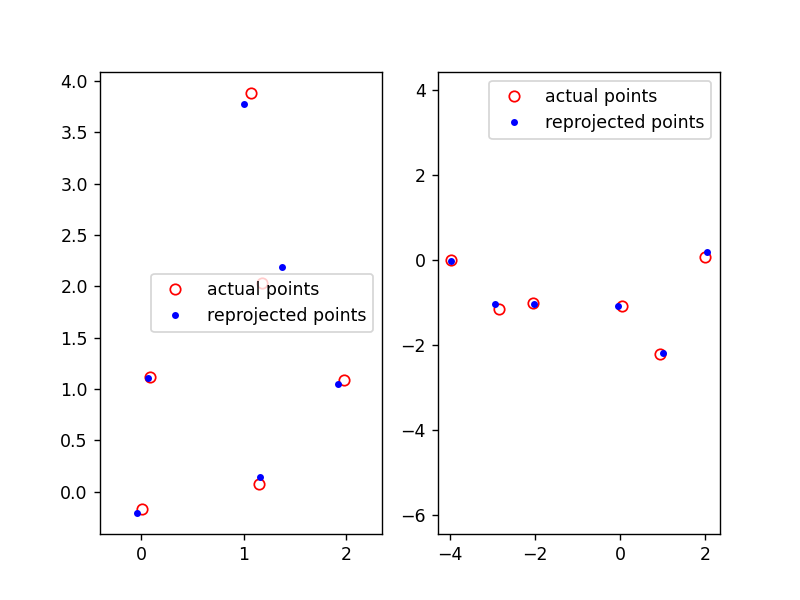

geometric error 
 0.14179084293259714
algebraic error
 0.0045777794548545895


In [39]:
### Define point correspondences and the data matrix.

Y = np.array([[0, 1, 1, 2, 1, 0],
              [0, 2, 4, 1, 0, 1],
              [1, 1, 1, 1, 1, 1]])


Yprime = np.array([[1, -3, -2, 2, 0, -4],
                   [-2, -1, -1, 0, -1, 0],
                   [1, 1, 1, 1, 1, 1]])

# Set noise level, and add random noise to the first two coordinates
sigma = 0.1

Z = Y + sigma * np.random.randn(*Y.shape)
Z[2, :] = 1

Zprime = Yprime + sigma * np.random.randn(*Y.shape)
Zprime[2, :] = 1

import math
# Define the geometric error function
def geometric_error(H, Y, Yprime):
    """returns the geometric error for the homography H with the point correspondences in Y and Yprime"""
    Yp = norm_P(H @ Y)
    Ypinv = norm_P(np.linalg.inv(H) @ Yprime)

    s = 0
    for i in range(Y.shape[1]):
    
      s = s + (Yprime[0,i]-Yp[0,i])**2+(Yprime[1,i]-Yp[1,i])**2 + (Y[0,i]-Ypinv[0,i])**2+(Y[1,i]-Ypinv[1,i])**2
    
    return s

# Estimate a homography H from the noisy points
# YOUR CODE HERE
###
u, s, V = np.linalg.svd(dlt_system(Z, Zprime))
v = V.T
v = v[:, 8]
H = np.reshape(v, (3,3)).T

###

Zmapped = norm_P(np.linalg.inv(H) @ Zprime)
Zprimemapped = norm_P(H @ Z)

# Plot the points and the transformed points
plt.subplot(1, 2, 1)
plt.plot(Z[0, :], Z[1, :], 'ro', mfc = 'None', mec = 'r')
plt.plot(Zmapped[0, :], Zmapped[1, :], 'b.')
plt.legend(['actual points', 'reprojected points'])
plt.axis('equal')
plt.subplot(1, 2, 2)
plt.plot(Zprime[0, :], Zprime[1, :], 'ro', mfc = 'None', mec = 'r')
plt.plot(Zprimemapped[0, :], Zprimemapped[1, :], 'b.')
plt.legend(['actual points', 'reprojected points'])
plt.axis('equal')
plt.show()


# Print the geometric error
print('geometric error \n',geometric_error(H, Z, Zprime))

# Print the algebraic error
# YOUR CODE HERE
A = dlt_system(Z, Zprime)
algerr = np.linalg.norm(A @ v)**2
print('algebraic error\n',algerr)

In [17]:
# This cell checks your teacher_tokens when submitted. Please ignore.